kafka consumer at 172.17.0.1:9092 is starting


<IPython.core.display.Javascript object>


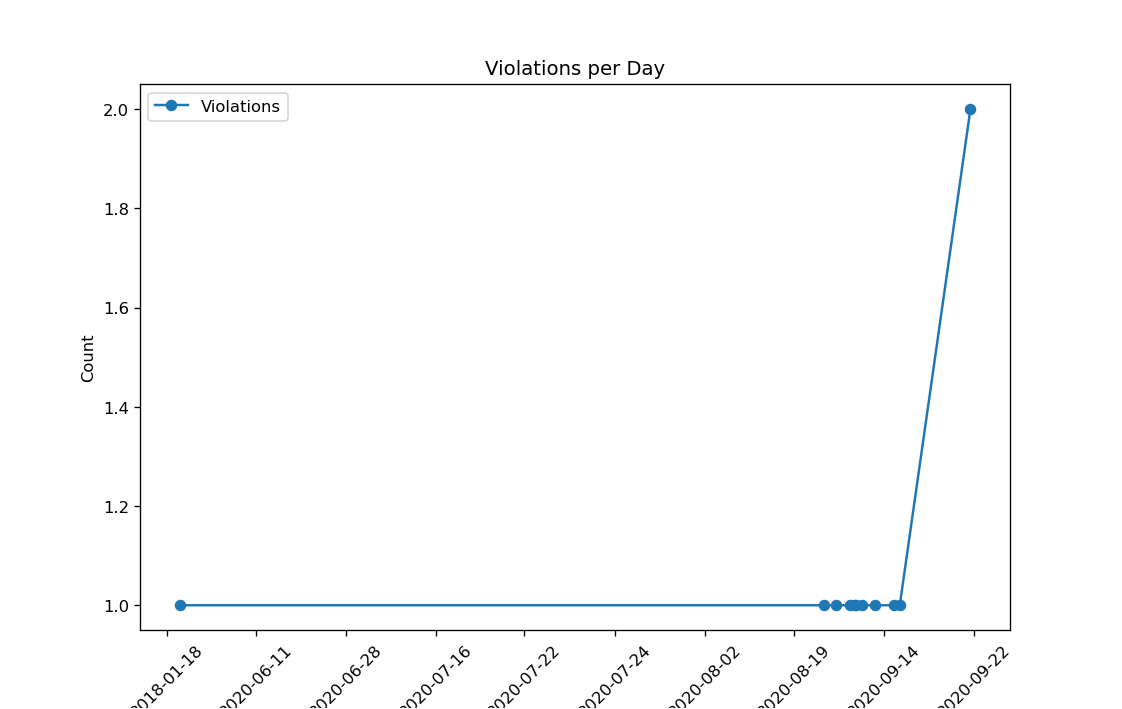

[INFO] Starting to consume and plot...


/tmp/ipykernel_1696/1369682142.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in days_sorted], rotation=45)


KeyboardInterrupt: 

In [3]:
#### TIMESTAMP PER DAY AND COUNT OF VIOLATIONS WITH MIN AND MAX

import json
from kafka3 import KafkaConsumer
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime

topic = "violation_historic"
kafka_server = "172.17.0.1:9092"

# Initialize Kafka consumer
consumer = KafkaConsumer(
    topic,
    bootstrap_servers=[kafka_server],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    value_deserializer=lambda m: json.loads(m.decode('utf-8'))
)

print("kafka consumer at "+ kafka_server+ " is starting")

# For Jupyter notebook use this line:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(9.5, 6))
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_title('Violations per Day')

day_counts = Counter()

def add_min_max(ax, x_data, y_data):
    if not y_data:
        return
    min_y = min(y_data)
    max_y = max(y_data)
    xpos_min = x_data[y_data.index(min_y)]
    xpos_max = x_data[y_data.index(max_y)]
    ax.annotate(f'Min: {min_y}', xy=(xpos_min, min_y), xytext=(xpos_min, min_y - 10),
                arrowprops=dict(facecolor='blue', shrink=0.05))
    ax.annotate(f'Max: {max_y}', xy=(xpos_max, max_y), xytext=(xpos_max, max_y + 10),
                arrowprops=dict(facecolor='red', shrink=0.05))

print("[INFO] Starting to consume and plot...")

while True:
    message_pack = consumer.poll(timeout_ms=1000, max_records=1)
    if not message_pack:
        continue
    for tp, messages in message_pack.items():
        for message in messages:
            event = message.value
            ts_str = event.get("timestamp_start")
            if not ts_str:
                continue
            try:
                dt_obj = datetime.fromisoformat(ts_str)
            except Exception:
                continue

            # Truncate to day
            dt_day = dt_obj.replace(hour=0, minute=0, second=0, microsecond=0)

            # Update counts
            day_counts[dt_day] += 1

            # Prepare sorted data for plotting
            days_sorted = sorted(day_counts.keys())
            counts_sorted = [day_counts[d] for d in days_sorted]

            # Clear and replot
            ax.clear()
            ax.plot(days_sorted, counts_sorted, marker='o', label="Violations")
            ax.set_title("Violations per Day")
            ax.set_xlabel("Date")
            ax.set_ylabel("Count")
            ax.tick_params(axis='x', rotation=45)
            ax.legend()

            # Format x-axis dates nicely
            ax.set_xticklabels([d.strftime('%Y-%m-%d') for d in days_sorted], rotation=45)

            # Add min/max annotations
            add_min_max(ax, days_sorted, counts_sorted)

            fig.canvas.draw()
            fig.canvas.flush_events()

            plt.pause(0.1)

            # Limit to last 10 days
            if len(days_sorted) > 10:
                oldest_day = days_sorted[0]
                del day_counts[oldest_day]


In [ ]:
import json
from kafka3 import KafkaConsumer
import matplotlib.pyplot as plt
from datetime import datetime

# Kafka setup
topic = "violation_historic"
kafka_server = "172.17.0.1:9092"

consumer = KafkaConsumer(
    topic,
    bootstrap_servers=[kafka_server],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    value_deserializer=lambda m: json.loads(m.decode('utf-8'))
)

# For Jupyter, enable interactive plotting
%matplotlib notebook

# Initialize plot
fig, ax = plt.subplots(figsize=(9.5, 6))
ax.set_xlabel('Time')
ax.set_ylabel('Speed')
ax.set_title('Speed of Violations Over Time')

# Containers
timestamp_container = []
speed_container = []

# Utility function to add annotations for min, max, avg
def add_stats(ax, x_data, y_data):
    if not y_data:
        return

    min_y = min(y_data)
    max_y = max(y_data)
    avg_y = sum(y_data) / len(y_data)

    xpos_min = x_data[y_data.index(min_y)]
    xpos_max = x_data[y_data.index(max_y)]
    xpos_avg = x_data[-1]  # annotate at the latest timestamp

    # Min annotation
    ax.annotate(f'Min: {min_y:.2f}', xy=(xpos_min, min_y), xytext=(xpos_min, min_y - 5),
                arrowprops=dict(facecolor='blue', shrink=0.05))

    # Max annotation
    ax.annotate(f'Max: {max_y:.2f}', xy=(xpos_max, max_y), xytext=(xpos_max, max_y + 5),
                arrowprops=dict(facecolor='red', shrink=0.05))

    # Average line and annotation
    ax.axhline(y=avg_y, color='green', linestyle='--', label=f'Avg: {avg_y:.2f}')
    ax.annotate(f'Avg: {avg_y:.2f}', xy=(xpos_avg, avg_y), xytext=(xpos_avg, avg_y + 5),
                arrowprops=dict(facecolor='green', shrink=0.05))

# Streaming loop
while True:
    message_pack = consumer.poll(timeout_ms=1000, max_records=1)
    if not message_pack:
        continue

    for tp, messages in message_pack.items():
        for message in messages:
            event = message.value

            # Parse timestamp and speed
            ts_str = event.get("timestamp_start")
            speed = event.get("speed")

            if ts_str is None or speed is None:
                continue

            try:
                timestamp = datetime.strptime(ts_str, "%Y-%m-%dT%H:%M:%S")
            except ValueError:
                continue

            timestamp_container.append(timestamp)
            speed_container.append(float(speed))

            # Clear and replot
            ax.clear()
            ax.set_title('Speed of Violations Over Time')
            ax.set_xlabel('Timestamp')
            ax.set_ylabel('Speed')
            ax.plot(timestamp_container, speed_container, marker='o', color='orange', label="Speed")
            add_stats(ax, timestamp_container, speed_container)
            ax.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.pause(0.1)
            ax.plot(timestamp_container, speed_container, marker='o', label="Speed")
            

            




In [ ]:
import json
from kafka3 import KafkaConsumer

# Define topic and Kafka broker
topic = "violations"
kafka_server = "172.17.0.1:9092" #put your own kafka ip here

# Create Kafka consumer
consumer = KafkaConsumer(
    topic,
    bootstrap_servers=[kafka_server],
    auto_offset_reset='earliest',
    enable_auto_commit=True,
    group_id="violation-consumer-group",
    value_deserializer=lambda m: json.loads(m.decode('utf-8'))
)

print(f"Consuming from topic: {topic} on {kafka_server}")

# Consume messages in a loop
try:
    for message in consumer:
        event = message.value
        print(f"Message received: {event}")
except KeyboardInterrupt:
    print("Stopped by user")
finally:
    consumer.close()
